In [1]:
import torch
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torch import nn


In [2]:
def calculate_phi(NPXLS):
    N= (NPXLS-1)/2
    A= torch.arange(-N, N+1)

    XX = torch.unsqueeze(A, dim= 0)
    YY = -torch.unsqueeze(A, dim= 1)

    X= torch.tile(XX, (NPXLS, 1))
    Y= torch.tile(YY, (1, NPXLS))

    phi = torch.atan2(Y, X)
    return phi

In [3]:
class psf_model(nn.Module):
    def __init__(self, NA, Rindex, lambda_, dx, Nx, Ny, Nz):
        super().__init__()
        self.NA= NA
        self.Rindex = Rindex
        self.lambda_ = lambda_
        self.dx= dx
        self.Nx = Nx
        self.Ny = Ny
        self.Nz = Nz
        self.Ntheta= 400 # n grid in polar angle

        self.abberations=  torch.nn.Parameter(torch.zeros((self.Ntheta, )).float())

        self.init_psf_params()

    def init_psf_params(self):
        self.alpha = np.arcsin(self.NA/ self.Rindex)
        self.dy= self.dx
        self.dz= self.dx

        #self.x = self.dx * torch.arange(-self.Nx/2, self.Nx/2)
        #self.y = self.dy * torch.arange(-self.Ny/2, self.Ny/2)
        #self.z = self.dz * torch.arange(-self.Nz/2, self.Nz/2)

        self.x = self.dx * torch.arange(-self.Nx//2+1, self.Nx//2+1)
        self.y = self.dy * torch.arange(-self.Ny//2+1, self.Ny//2+1)
        self.z = self.dz * torch.arange(-self.Nz//2+1, self.Nz//2+1)

        self.dtheta = self.alpha/ self.Ntheta
        self.theta = torch.arange(0, self.Ntheta)*self.dtheta

        assert self.Nx== self.Ny, "self.Nx != self.Ny -> self.Phi calculation wrong !!!"
        self.Phi= calculate_phi(self.Nx)
        self.A= np.pi/ self.lambda_

        self.X, self.Y, self.THETA = torch.meshgrid(self.x, self.y, self.theta)

        V= (2*np.pi/ self.lambda_)* torch.sqrt(self.X**2 + self.Y**2).numpy() #k.r
        J0= torch.from_numpy(scipy.special.jv(0, V* np.sin(self.THETA.numpy())))
        J1= torch.from_numpy(scipy.special.jv(1, V* np.sin(self.THETA.numpy())))
        J2= torch.from_numpy(scipy.special.jv(2, V* np.sin(self.THETA.numpy())))

        self.Func0 = torch.sqrt(torch.cos(self.THETA))* torch.sin(self.THETA) * (1+ torch.cos(self.THETA)) * J0
        self.Func1 = torch.sqrt(torch.cos(self.THETA))* (torch.sin(self.THETA)**2) * J1
        self.Func2 = torch.sqrt(torch.cos(self.THETA))* torch.sin(self.THETA) * (1- torch.cos(self.THETA)) * J2

        self.U = 2*np.pi/ self.lambda_ * self.z # k.z


    def forward(self):
        device= self.abberations.device
        ABBR = torch.tile(self.abberations, (self.x.shape[0], self.y.shape[0], 1))

        Func0 = self.Func0.to(device) *torch.exp(1j * ABBR)
        Func1 = self.Func1.to(device) *torch.exp(1j * ABBR)
        Func2 = self.Func2.to(device) *torch.exp(1j * ABBR)

        PSF_3D = torch.zeros((3, self.Nx, self.Ny, self.Nz), dtype = torch.cfloat).to(device)

        for k in range(len(self.U)):
            Func3_atThisU = torch.exp(-1j * self.U[k] * torch.cos(self.THETA)).to(device)

            I0 = torch.trapz(y= Func0 * Func3_atThisU, x= self.theta.to(device), axis= 2) #axis: alpha
            I1 = torch.trapz(y= Func1 * Func3_atThisU, x= self.theta.to(device), axis= 2) #axis: alpha
            I2 = torch.trapz(y= Func2 * Func3_atThisU, x= self.theta.to(device), axis= 2) #axis: alpha

            Ex = 1j * self.A * (I0 + I2 * torch.cos(2*self.Phi.to(device)))
            Ey = 1j * self.A * I2 * torch.sin(2*self.Phi.to(device))
            Ez = (-2) * self.A* I1 * torch.cos(self.Phi.to(device))

            # Es = 1j * A * I0 ## scalar approx
            PSF_3D[0, :, :, k] = Ex
            PSF_3D[1, :, :, k] = Ey
            PSF_3D[2, :, :, k] = Ez

        return PSF_3D

        #IPSF = (PSF_3D.abs()**2).sum(dim= 0)
        #IPSF = IPSF/ torch.sqrt((IPSF**2).sum())
        #return IPSF.permute(2,0,1).unsqueeze(dim=0) #channel first, add batch dim

In [4]:
def show_psf(PSF_3D):
    _, Nx, Ny, Nz = PSF_3D.shape

    plt.figure(figsize = (12, 3))
    plt.subplot(1,3,1)
    plt.imshow(PSF_3D[0, :, :, Nz//2].abs())
    plt.title('x-axis')
    plt.colorbar(fraction = 0.025)

    plt.subplot(1,3,2)
    plt.imshow(PSF_3D[1, :, :, Nz//2].abs())
    plt.title('y-axis')
    plt.colorbar(fraction = 0.025)

    plt.subplot(1,3,3)
    plt.imshow(PSF_3D[2, :, :, Nz//2].abs())
    plt.title('z-axis')
    plt.colorbar(fraction = 0.025)

    plt.suptitle('3D PSF : ABS', y= 1.01)
    plt.show()


    plt.figure(figsize = (12, 3))
    plt.subplot(1,3,1)
    plt.imshow(PSF_3D[0, :, :, Nz//2].angle())
    plt.title('x-axis')
    plt.colorbar(fraction = 0.025)

    plt.subplot(1,3,2)
    plt.imshow(PSF_3D[1, :, :, Nz//2].angle())
    plt.title('y-axis')
    plt.colorbar(fraction = 0.025)

    plt.subplot(1,3,3)
    plt.imshow(PSF_3D[2, :, :, Nz//2].angle())
    plt.title('z-axis')
    plt.colorbar(fraction = 0.025)

    plt.suptitle('3D PSF : ANGLE', y= 1.01)
    plt.show()

In [5]:
def show_along_z(PSF_3D):
    _, Nx, Ny, Nz = PSF_3D.shape
    IPSF = (PSF_3D.abs()**2).sum(dim= 0)

    plt.figure(figsize = (6, 6))

    plt.subplot(1,2,1)
    plt.imshow(torch.log(TF.center_crop(IPSF[Nx//2, :, :], (50, 130)).T), cmap = 'gray')
    plt.title('IPSF: YZ')
    plt.colorbar(fraction= 0.03)

    plt.subplot(1,2,2)
    plt.imshow(torch.log(TF.center_crop(IPSF[:, Ny//2, :], (50, 130)).T), cmap = 'gray')
    plt.title('IPSF: XZ')
    plt.colorbar(fraction= 0.03)
    plt.show()


    plt.figure(figsize = (6, 6))

    plt.subplot(1,2,1)
    plt.imshow(torch.log(TF.center_crop(PSF_3D[0, Nx//2, :, :].angle(), (50, 130)).T), cmap = 'gray')
    plt.title('PPSF-x: YZ')
    plt.colorbar(fraction= 0.03)

    plt.subplot(1,2,2)
    plt.imshow(torch.log(TF.center_crop(PSF_3D[0, Nx//2, :, :].angle(), (50, 130)).T), cmap = 'gray')
    plt.title('PPSF-x: XZ')
    plt.colorbar(fraction= 0.03)
    plt.show()

In [6]:
def Coherent(ht_2d, exPSF_3D):
    ht_3d = torch.zeros(1, Nz, Nx, Ny).float().to(device)
    ht_3d[:, Nz //2] = ht_2d

    #Ht_fft = torch.fft.fftn(ht_3d, dim =(-3, -2, -1))
    #exPSF_fft = torch.fft.fftn(exPSF_3D, dim =(-3, -2, -1))
    #conv_exPSF_Ht = torch.fft.ifftn(torch.fft.ifftshift(torch.fft.fftshift(exPSF_fft * Ht_fft, dim =(-3, -2, -1)), dim =(-3, -2, -1)), dim =(-3, -2, -1))

    Ht_fft = torch.fft.fftshift(torch.fft.fftn(torch.fft.ifftshift(ht_3d, dim =(-3, -2, -1)), dim =(-3, -2, -1)), dim =(-3, -2, -1))
    exPSF_fft = torch.fft.fftshift(torch.fft.fftn(torch.fft.ifftshift(exPSF_3D, dim =(-3, -2, -1)), dim =(-3, -2, -1)), dim =(-3, -2, -1))
    conv_exPSF_Ht = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(exPSF_fft * Ht_fft, dim =(-3, -2, -1)), dim =(-3, -2, -1)), dim =(-3, -2, -1))


    Zt = (conv_exPSF_Ht.abs()**2).sum(dim= 0)
    return Zt

def Incoherent(ht_2d, exPSF_3D):

    exPSF_3D = (exPSF_3D.abs()**2).sum(dim= 0).unsqueeze(dim= 0) #IPSF

    ht_3d = torch.zeros(1, Nz, Nx, Ny).float().to(device)
    ht_3d[:, Nz //2] = ht_2d

    #Ht_fft = torch.fft.fftn(ht_3d, dim =(-3, -2, -1))
    #exPSF_fft = torch.fft.fftn(IPSF, dim =(-3, -2, -1))
    #conv_exPSF_Ht = torch.fft.ifftn(torch.fft.ifftshift(torch.fft.fftshift(exPSF_fft * Ht_fft, dim =(-3, -2, -1)), dim =(-3, -2, -1)), dim =(-3, -2, -1))

    Ht_fft = torch.fft.fftshift(torch.fft.fftn(torch.fft.ifftshift(ht_3d, dim =(-3, -2, -1)), dim =(-3, -2, -1)), dim =(-3, -2, -1))
    exPSF_fft = torch.fft.fftshift(torch.fft.fftn(torch.fft.ifftshift(exPSF_3D, dim =(-3, -2, -1)), dim =(-3, -2, -1)), dim =(-3, -2, -1))
    conv_exPSF_Ht = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(exPSF_fft * Ht_fft, dim =(-3, -2, -1)), dim =(-3, -2, -1)), dim =(-3, -2, -1))

    assert conv_exPSF_Ht.shape[0]==1, "conv_exPSF_Ht.shape[0] should be 1 !!!"

    Zt = conv_exPSF_Ht.abs()[0]
    # Zt = (conv_exPSF_Ht.abs()**2).sum(dim= 0)
    return Zt

In [7]:
def show_planes(outs, title): #outs.shape: [Nz, Nx, Ny]
    z_planes= range(0, Nz, 10)
    plt.figure(figsize= (20, 2))
    for i, z_idx in enumerate(z_planes):
        plt.subplot(1, len(z_planes), i+1)
        plt.imshow(outs[z_idx], vmin= outs.min(), vmax= outs.max())
        plt.axis('off')
        plt.title(f'z: {z_idx}')

    plt.suptitle(f'{title} | min: {round(outs.min(), 2)}, max: {round(outs.max(), 2)}\n')
    plt.show()

In [11]:
NA = 0.25
Rindex= 1.518
lambda_= 532.0/ 1000 #um
dx= 2.0 #um
Nx= 121
Ny= 121
Nz= 121

device= 'cuda'
psf = psf_model(NA, Rindex, lambda_, dx, Nx, Ny, Nz).to(device)

exPSF_3D = psf().detach().permute(0,3,1,2)

In [12]:
patch_size= 6
#ht_2d= (torch.randn(Nx, Ny)>0.0).float()

ht_2d= (torch.randn(Nx//patch_size, Ny//patch_size)>0.0).float()
ht_2d = ht_2d.repeat_interleave(patch_size+1, dim= 0).repeat_interleave(patch_size+1, dim= 1)[:Nx, :Ny]

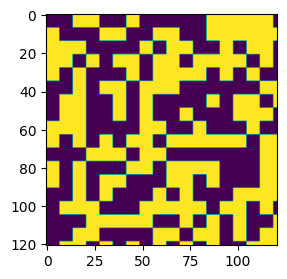

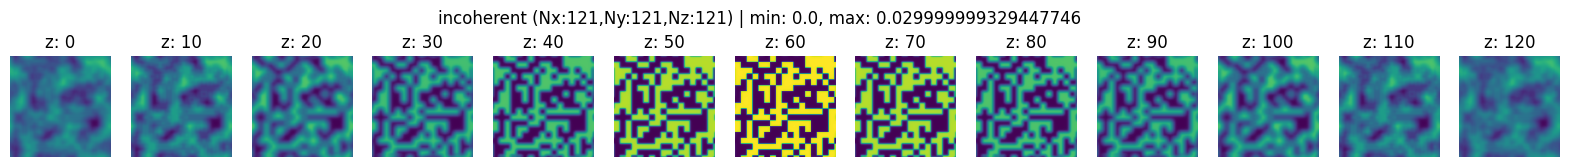

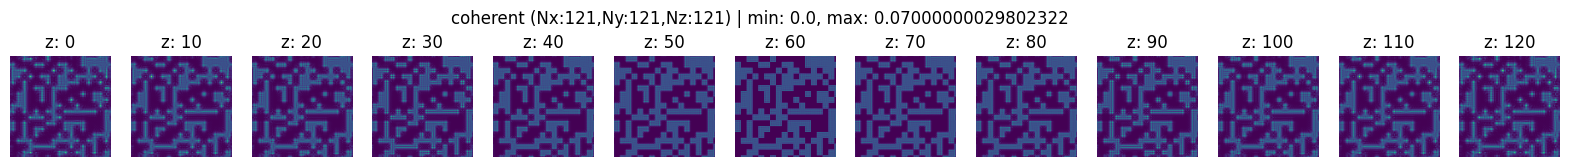

In [13]:
incoherent_out = Incoherent(ht_2d, exPSF_3D).detach().cpu().numpy()
coherent_out = Coherent(ht_2d, exPSF_3D).detach().cpu().numpy()

plt.figure(figsize= (3,3))
plt.imshow(ht_2d)

show_planes(incoherent_out, title= f'incoherent (Nx:{Nx},Ny:{Ny},Nz:{Nz})')
show_planes(coherent_out, title= f'coherent (Nx:{Nx},Ny:{Ny},Nz:{Nz})')